In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

In [3]:
sig = 10.
rho = 28.
beta = 8./3

def Lorenz_model(v, sig=sig, rho=rho, beta=beta):
    x, y, z = v[...,0], v[...,1], v[...,2]
    
    dxdt = sig*(y-x)
    dydt = rho*x - y - x*z
    dzdt = x*y - beta*z
    
    return np.stack((dxdt, dydt, dzdt),axis=-1)

In [4]:
def RK4 (model, v, dt):
    k1 = model(v)
    k2 = model(v + dt*k1/2.)
    k3 = model(v + dt*k2/2.)
    k4 = model(v + dt*k3)
    return v + (1./6.)*dt*(k1 + 2*k2 + 2*k3 + k4)

In [5]:
v0 = np.array([1.509, -1.531, 25.46]) + 0.1*np.random.randn(3)
K = 50000
dt = 0.01


In [6]:
def simulate(forward, K, v0, N=0, burnin=500):
    """
    simulate an ensemble of forward models over K time steps.
    :forward: forward model
    :K: number of time steps to generate
    :N: enseømble size (if N=0, no ensemble)
    :v0: initial state (shape: (3,N)), if N=0. (shape: (3))
    :burnin: number of initial time step to discard (spinup period)
    """
    V = np.zeros((K+burnin,N,3)) if N>0 else np.zeros((K+burnin,3)) 
    V[0] = v0
    for i in range(1,K+burnin):
        V[i] =forward(V[i-1])
    return V[burnin:]

In [7]:
forward = lambda v: RK4(Lorenz_model, v,dt)

V = simulate(forward, K, v0)

In [8]:
V.shape

(50000, 3)

In [9]:
def phase_plot(V):
    """
    Plot the trajectory V in dense plot in the phase space
    """
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
    ax[1,0].hist2d(V[:,0],V[:,1], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[0,0].hist2d(V[:,0],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[0,1].hist2d(V[:,1],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[1,1].axis('off');
    return fig, ax 

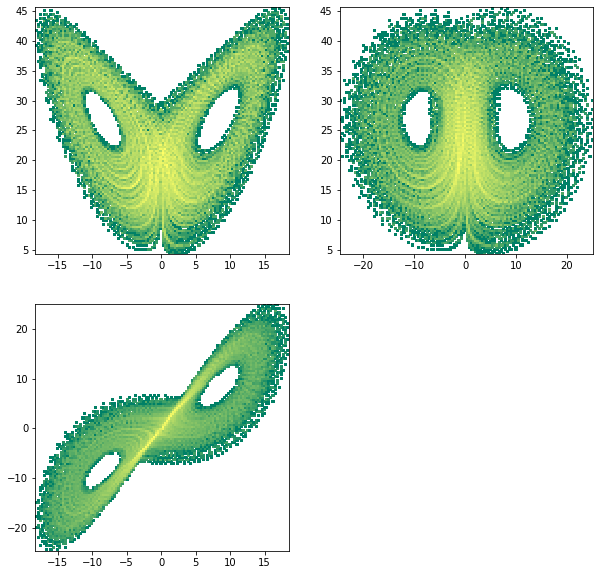

In [10]:
fig, ax = phase_plot(V)

In [11]:
# Training set/Val
Ktrain=10000
Kval = 5000
Ktest = 2000

Xtrain = V[0:Ktrain]
ytrain = V[1:Ktrain+1]

Xval = V[Ktrain:Ktrain+Kval]
yval = V[Ktrain+1:Ktrain+Kval+1]

Xval.shape

(5000, 3)

In [12]:
# Test set (ensemble)
v0test = np.array([1.509, -1.531, 25.46])[np.newaxis,:] + 0.1*np.random.randn(200,3)
Vtest = simulate(forward, Ktest, v0test, N=200)
v0test.shape


(200, 3)

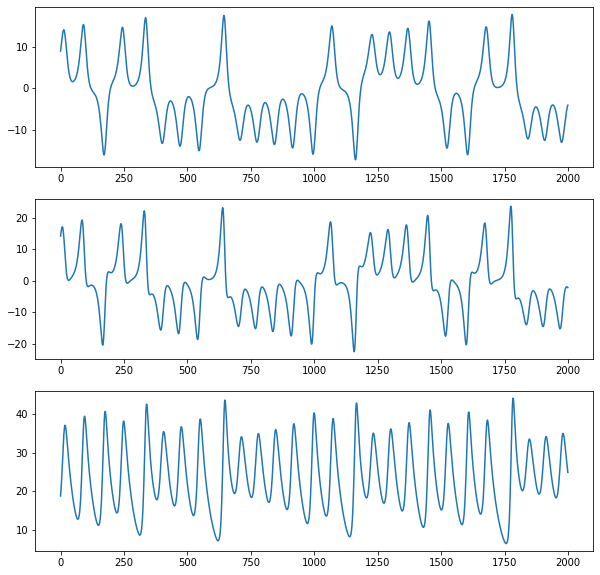

In [13]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])


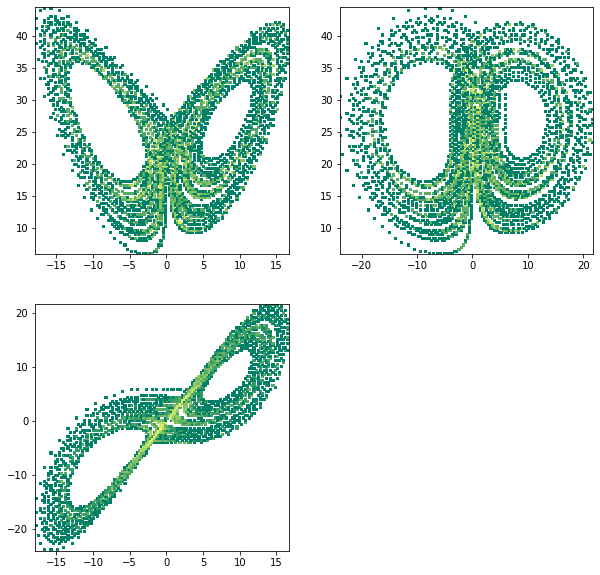

In [14]:
fig, ax = phase_plot(Xval)

In [15]:
reg = LinearRegression().fit(Xtrain, ytrain)


In [16]:
ylin = reg.predict(Xval)

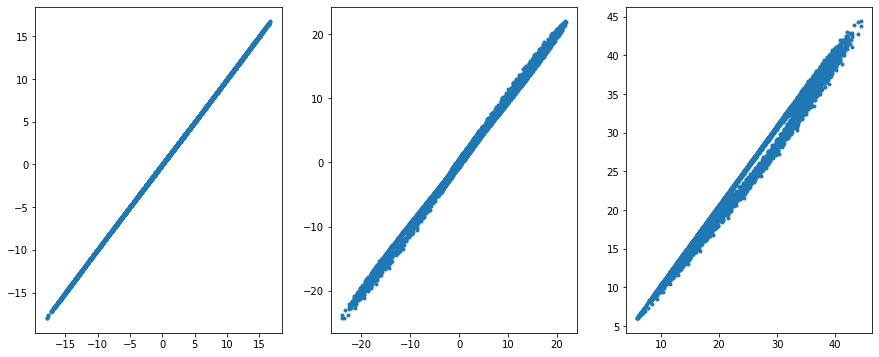

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ylin[:,0],'.')
ax[1].plot(yval[:,1],ylin[:,1],'.')
ax[2].plot(yval[:,2],ylin[:,2],'.')

In [18]:
Vtestlin = simulate(reg.predict, Ktest, Vtest[0], N=200,burnin=0)


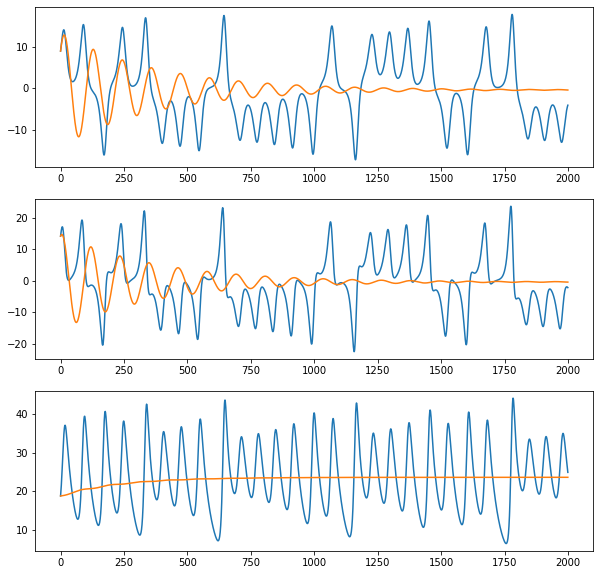

In [19]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])
ax[0].plot(Vtestlin[:,0,0])
ax[1].plot(Vtestlin[:,0,1])
ax[2].plot(Vtestlin[:,0,2])

In [20]:
import tensorflow.keras as keras


In [21]:
mean_ = np.mean(Xtrain,axis=0,keepdims=True)
std_= np.std(Xtrain,axis=0, keepdims=True)


norm = lambda x: (x-mean_)/std_
denorm = lambda x: x*std_ + mean_


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
nn_model = keras.Sequential(
    [
        layers.Dense(40, activation="relu", name="layer1", input_shape=(3,)),
        layers.Dense(20, activation="relu", name="layer2"),
        layers.Dense(3, name="output"),
    ])

In [24]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 40)                160       
_________________________________________________________________
layer2 (Dense)               (None, 20)                820       
_________________________________________________________________
output (Dense)               (None, 3)                 63        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________


In [25]:
nn_model.compile(optimizer='Adam', loss='mse')

In [26]:
history = nn_model.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=50)

Epoch 1/50
313/313 [==============================] - 2s 4ms/step - loss: 195.3545 - val_loss: 10.4199
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 7.2005 - val_loss: 2.1220
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 1.6725 - val_loss: 0.6465
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.4968 - val_loss: 0.1843
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.1733 - val_loss: 0.0825
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0829 - val_loss: 0.0434
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0478 - val_loss: 0.0297
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0218
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0173
Epoch 10/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0

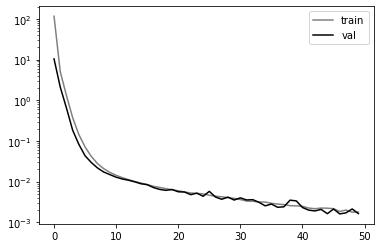

In [27]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'],color='gray',label='train')
ax.semilogy(history.history['val_loss'],color='black',label='val')
ax.legend()

In [35]:
ynn = nn_model.predict(norm(Xval))

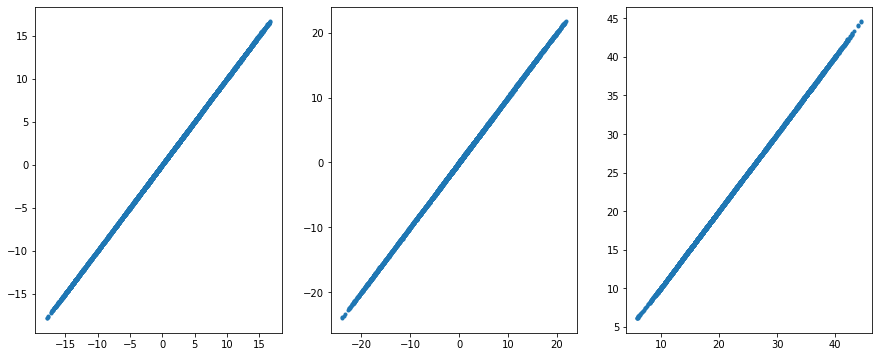

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ynn[:,0],'.')
ax[1].plot(yval[:,1],ynn[:,1],'.')
ax[2].plot(yval[:,2],ynn[:,2],'.')

In [30]:
forward_nn = lambda v: nn_model.predict(norm(v))

In [31]:
Vtestnn = simulate(forward_nn, Ktest, Vtest[0], N=200,burnin=0)


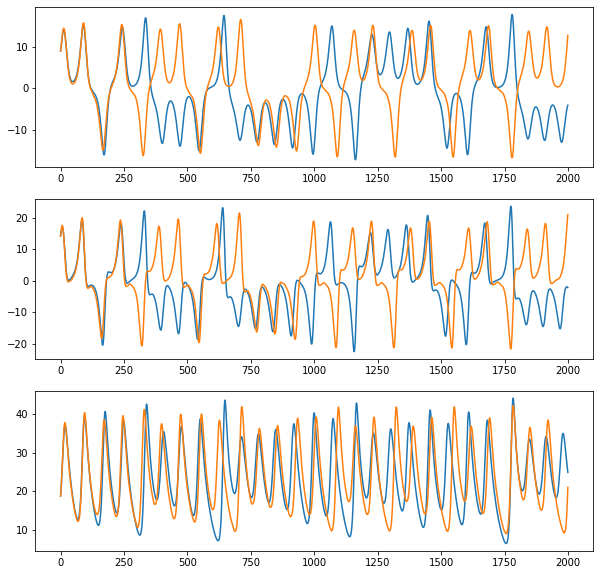

In [32]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])
ax[0].plot(Vtestnn[:,0,0])
ax[1].plot(Vtestnn[:,0,1])
ax[2].plot(Vtestnn[:,0,2])

In [33]:
Vtestnn = simulate(forward_nn, K, Vtest[0,0], burnin=0)


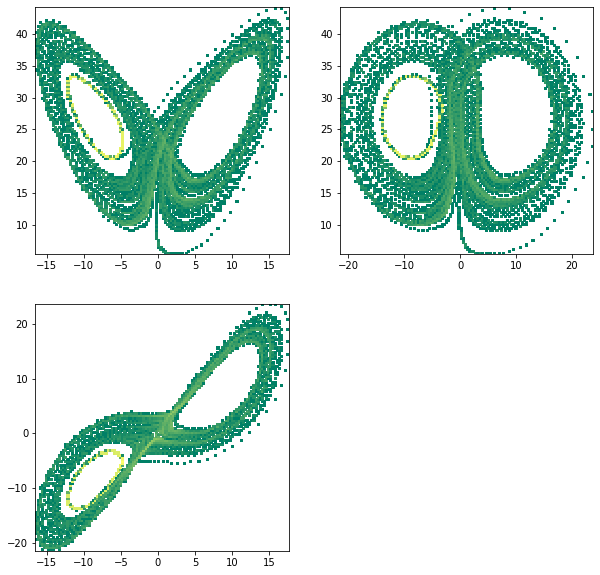

In [34]:
fig, ax = phase_plot(Vtestnn)